<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  EXP:1 LightGBM  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the IRIS dataset.

Sensitivity to training set details:
https://nbviewer.jupyter.org/github/Azure/azureml-examples/blob/main/notebooks/train-lightgbm-local.ipynb


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [25]:
%watermark

2020-11-24T23:28:52+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [26]:
# Initialization:
%reload_ext autoreload
%autoreload 2

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
!pip install lightgbm

In [28]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,mlxtend,sklearn,lightgbm

Habtamu desalegn 
last updated: 2020-11-24 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
mlxtend 0.17.3
sklearn 0.23.2
lightgbm 3.1.0


In [29]:
# Downloading the Libraries and Dependencies:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from typing import Tuple
%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the IRIS dataset

In [30]:
COLUMNS = ["sepal_length","sepal_width","petal_length","petal_width","species"]
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [31]:
from sklearn.preprocessing import LabelEncoder

X = df.drop('species', axis=1).values
y = df['species']

enc = LabelEncoder()
y = enc.fit_transform(y)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [33]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)


<a id="classifier"></a>
## 2. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#2_1)
2. [Train a model: LightGBM](#2_2)
3. [Evaluate the model](#2_3)

<a id="2_1"></a>
### 1. Data Scaling

Bringing features onto the same scale

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def preprocess_minmax(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization -- Min-max scaling

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param X_train: Data instances.
    :param X_test: Data instances.
    :return: Rescaled values of `X_train`, `X_test`.
    """
    
    # normalize
    #print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))
    
    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train)
    X_test_norm = mms.transform(X_test)
    
    return X_train_norm, X_test_norm

def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

In [35]:
# Preprocess - Training and testing set
### standard
#(X_train, X_test) = preprocess_standard(X_train[:,[0,1]], X_test[:,[0,1]])    #  0=sepal length, 1=sepal width
(X_train, X_test) = preprocess_standard(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### normalize
#(X_train, X_test) = preprocess_minmax(X_train[:,[0,1]], X_test[:,[0,1]])     #  0=sepal length, 1=sepal width
#(X_train, X_test) = preprocess_minmax(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### with out normalization
#(X_train, X_test) = X_train[:,[0,1]], X_test[:,[0,1]]      #  0=sepal length, 1=sepal width
#(X_train, X_test) = X_train[:,2:], X_test[:,2:]            #  2=petal length, 3=petal width


<a id="2_2_1"></a>
### 2.1 Train with LightGBM

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [36]:
# Model Training: lightgbm
import lightgbm as lgb

# set training parameters
params = {
    "boosting_type":'gbdt',     # boosting type, support gbdt for now, alias: boosting, boost
    "objective": "multiclass",  # multiclass , for >=3 class classification task
    "num_class": 3,             # number of classes (species)
    "learning_rate": 0.2,       # shrinkage rate
    "num_leaves": 20,           # number of leaves for one tree
    "min_data_in_leaf": 10,     # minimal number data for one leaf, use this to deal with over-fit 
    "metric": "multi_logloss", # multi_logloss , metric for for >=3 class classification task
    "seed": 42,
}

num_boost_round = 100            #"num_trees": 100,  # number of trees(iterations)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# data is ready to train
model = lgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[test_data],
        valid_names=["test"]
      )

print(f'model: {model}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 2
[LightGBM] [Info] Start training from score -1.219973
[LightGBM] [Info] Start training from score -1.043042
[LightGBM] [Info] Start training from score -1.043042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	test's multi_logloss: 0.783746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics


In [40]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_pred_bin = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test_bin, y_pred_bin, average)


y_proba = model.predict(X_test)
y_pred = y_proba.argmax(axis=1)
print(f"pred: {y_pred}")
print(f"y_true: {y_test}")
loss = metrics.log_loss(y_test, y_proba)
print(f"loss: {loss}")    
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
print('\n[Precision]')
precision = metrics.precision_score(y_test, y_pred, average=None)
print(f'Individual: {precision[0]:.2f}, {precision[1]:.2f}, {precision[2]:.2f}')
precision = metrics.precision_score(y_test, y_pred, average='micro')
print(f"micro: {precision}")
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"macro: {precision}")

# Recall
print('\n[Recall]')
recall = metrics.recall_score(y_test, y_pred, average=None)
print(f'Individual: {recall[0]:.2f}, {recall[1]:.2f}, {recall[2]:.2f}')
recall = metrics.recall_score(y_test, y_pred, average='micro')
print(f"micro: {recall}")
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"macro: {recall}")

# F1
print('\n[F1-score]')
f1 = metrics.f1_score(y_test, y_pred, average=None)
print(f'Individual: {f1[0]:.2f}, {f1[1]:.2f}, {f1[2]:.2f}')
f1 = metrics.f1_score(y_test, y_pred, average='micro')
print(f"micro: {f1}")
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"macro: {f1}")

# AUC
print('\n[ROC AUC]')
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"macro: {auc}")

# classification_report
print(f"\nclassification_report:\n {metrics.classification_report(y_test, y_pred)}")


pred: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 2 1 0 0]
y_true: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
loss: 0.11194447784476004
Misclassified examples:1
confusion matrix:
 [[19  0  0]
 [ 0 12  1]
 [ 0  0 13]]
Accuracy: 0.9777777777777777

[Precision]
Individual: 1.00, 1.00, 0.93
micro: 0.9777777777777777
macro: 0.9761904761904763

[Recall]
Individual: 1.00, 0.92, 1.00
micro: 0.9777777777777777
macro: 0.9743589743589745

[F1-score]
Individual: 1.00, 0.96, 0.96
micro: 0.9777777777777777
macro: 0.974320987654321

[ROC AUC]
macro: 0.9819711538461539

classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45

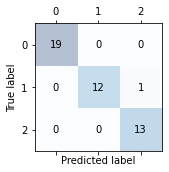

In [41]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 2
[LightGBM] [Info] Start training from score -1.219973
[LightGBM] [Info] Start training from score -1.043042
[LightGBM] [Info] Start training from score -1.043042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	test's multi_logloss: 0.783746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	test's multi_logloss: 0.588433
[LightGBM] [Warning] Auto-choos

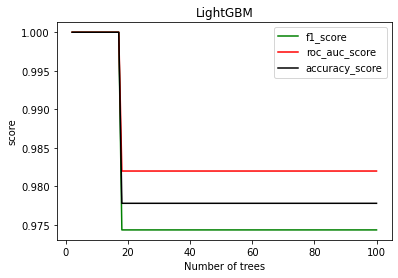

In [42]:
# imports
import time

# set training parameters
params = {
    "boosting_type":'gbdt',     # boosting type, support gbdt for now, alias: boosting, boost
    "objective": "multiclass",  # multiclass , for >=3 class classification task
    "num_class": 3,             # number of classes (species)
    "learning_rate": 0.2,       # shrinkage rate
    "num_leaves": 20,           # number of leaves for one tree
    "min_data_in_leaf": 10,     # minimal number data for one leaf, use this to deal with over-fit 
    "metric": "multi_logloss", # multi_logloss , metric for for >=3 class classification task
    "seed": 42,
}

def train_model(params, num_boost_round, X_train, X_test, y_train, y_test):
    t1 = time.time()
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[test_data],
        valid_names=["test"],
    )
    t2 = time.time()

    return model, t2 - t1


def evaluate_model(model, X_test, y_test):
    y_proba = model.predict(X_test)
    y_pred = y_proba.argmax(axis=1)
    
    loss = metrics.log_loss(y_test, y_proba)
    acc = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    
    return loss, acc, recall, precision, auc, f1


max_c = 0;
max_j = 0;

y_loss = []
y_acc = []
y_recall = []
y_precision = []
y_auc = []
y_fsc = []

x_vals = np.linspace(2, 100, 99).astype(int)

for j in x_vals:
    # train model
    model, train_time = train_model(params, j , X_train, X_test, y_train, y_test)
    loss, acc, recall, precision, auc, f1 = evaluate_model(model, X_test, y_test)
    y_loss.append(loss)
    y_acc.append(acc)
    y_recall.append(recall)
    y_precision.append(precision)
    y_auc.append(auc)
    y_fsc.append(f1)
    
    if f1 > max_c:
        max_c = f1
        max_j = j

# print("Max f1_score on max_depth  ",  max_j, " is ", max_c)
plt.figure()
plt.xlabel('Number of trees')
plt.ylabel('score')
plt.title('LightGBM')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
plt.plot(x_vals, y_auc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")
#plt.plot(x_vals, y_loss, color = "yellow", label = "loss")

plt.legend()

## 5 Adversarial-Robustness-Toolbox for scikit-learn LightGBM